In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
# https://medium.com/@devamsheth20/statistical-test-for-k-means-cluster-validation-in-python-using-sorted-similarity-matrix-1e644ab029c0
from sklearn import datasets
data = datasets.load_iris(as_frame=True).frame
data


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [2]:
X = data.iloc[:,:-1]
y = data.target

## Let's use t-sne to project the data to 2D

In [3]:
from sklearn.manifold import TSNE
Embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=5).fit_transform(X)
# Embedded = TSNE(n_components=2, learning_rate='auto',
#                     init='random', perplexity=3).fit_transform(X_train)
colorMp = list(y.values)

In [4]:
print(Embedded.shape)

(150, 2)


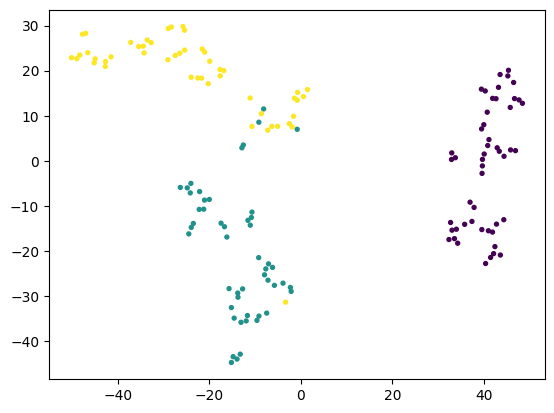

In [5]:
import matplotlib.pyplot as plt

plt.scatter(Embedded[:,0],Embedded[:,1],c=colorMp,s=8)

## Let's see how k-means group the data

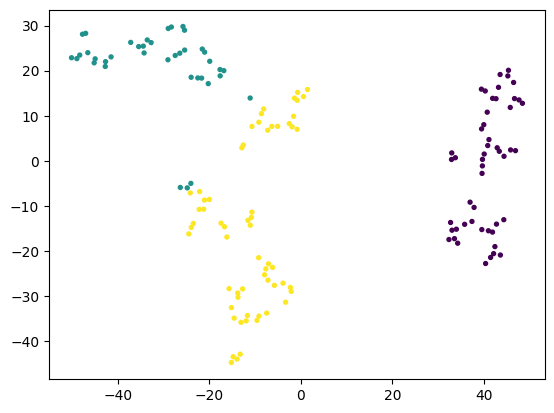

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
plt.figure()
plt.scatter(Embedded[:,0],Embedded[:,1],c=kmeans.labels_,s=8)


#### Let's validate the clustering solution

### How if you want to use brute-force search for the best $k$

SSE of Given data when k = 0 is 681.3706
SSE of Given data when k = 1 is 152.3479517603579
SSE of Given data when k = 2 is 78.85566582597731
SSE of Given data when k = 3 is 57.38387326549494
SSE of Given data when k = 4 is 46.47223015873017
SSE of Given data when k = 5 is 39.38030324250913
SSE of Given data when k = 6 is 35.0498292091351
SSE of Given data when k = 7 is 33.39648287496818
SSE of Given data when k = 8 is 29.610697177822175


<StemContainer object of 3 artists>

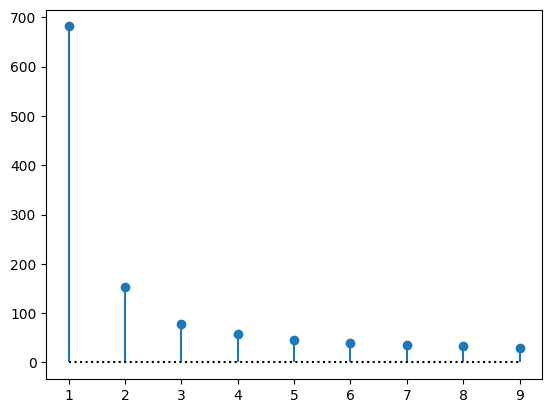

In [7]:
from sklearn.cluster import KMeans
sseLst = []
for k in range(9):
  kmeans = KMeans(n_clusters=k+1, random_state=0, n_init="auto").fit(X)
  sse = kmeans.inertia_
  sseLst.append(sse)
  print(F"SSE of Given data when k = {k} is {sse}")
plt.figure()
plt.stem(np.arange(1,10,1), sseLst,basefmt = 'k:')


### Let's use the sorted similarity matrix to validate the clustering results.

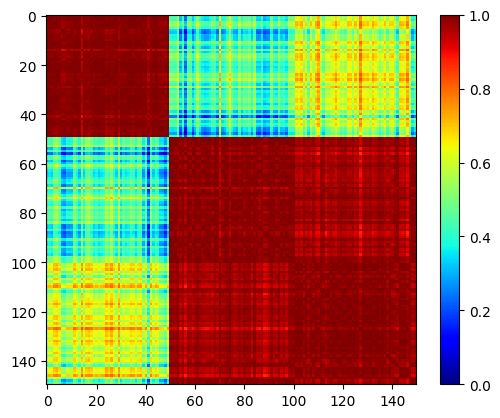

In [8]:
# ported from: https://medium.com/@devamsheth20/statistical-test-for-k-means-cluster-validation-in-python-using-sorted-similarity-matrix-1e644ab029c0
import numpy as np
from sklearn.metrics import pairwise_distances

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
clf = kmeans

# pairwisedist = pairwise_distances(scaleddf, metric='cosine')
pairwisedist = pairwise_distances(X, metric='cosine')

# sorting by labels
sorted_pairwisedist = pairwisedist[np.argsort(clf.labels_)][:, np.argsort(clf.labels_)]
labels = clf.labels_[np.argsort(clf.labels_)]

# keeping the distance values between 0 and 1.
sorted_pairwisedist = sorted_pairwisedist / np.max(sorted_pairwisedist)
sorted_similarity = 1- sorted_pairwisedist / np.max(sorted_pairwisedist)

#plotting
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(sorted_similarity,cmap ='jet',interpolation='none')
plt.colorbar()


#### Another way to validate is to compare with random points

[(4.3, 7.9), (2.0, 4.4), (1.0, 6.9), (0.1, 2.5)]


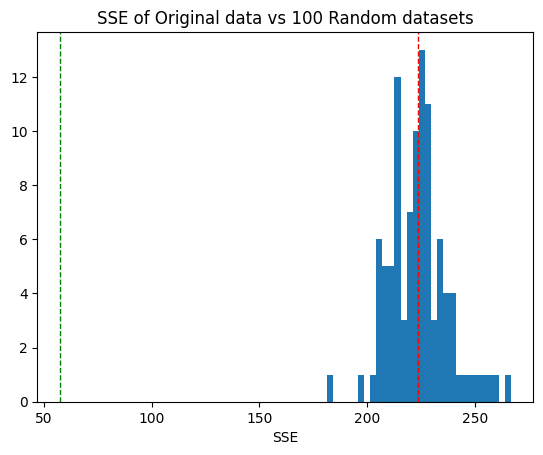

In [9]:
corrhist =[]
ssehist =[]
data = X.copy()
ranges = [(data[col].min(), data[col].max()) for col in data.columns] # specify different ranges for each column
print(ranges)
for seed in range(0,100):
  np.random.seed(seed)
  randomdata = np.random.default_rng().uniform(low=ranges[0][0], high=ranges[0][1], size=(100, 1))
  for r in ranges[1:]:
      randomdata = np.concatenate((randomdata, np.random.uniform(low=r[0], high=r[1], size=(100, 1))), axis=1)
  randomdf = pd.DataFrame(randomdata)

#scaling random df
  # scaledranddf = scaler.fit_transform(randomdf)
  scaledranddf = randomdf
#clustering each df
  clfr = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(scaledranddf)
  labels = clfr.labels_[np.argsort(clfr.labels_)]

#distance matrix for each random df
  pairwisedistr = pairwise_distances(scaledranddf, metric='cosine')
  sorted_pairwisedistr = pairwisedist[np.argsort(labels)][:, np.argsort(labels)]

#Ideal Similarity matrix for each randomdf
  incidence_matrixr = np.zeros_like(sorted_pairwisedistr)
  for i in range(len(labels)):
      for j in range(len(labels)):
          incidence_matrixr[i,j] = int(labels[i] == labels[j])

#calculating correlation of proximity matrix(distance) and Incidence matrix (Ideal similarity)
  corrhist.append(np.corrcoef(sorted_pairwisedistr.flatten(), incidence_matrixr.flatten())[0, 1])
  ssehist.append(clfr.inertia_)

plt.hist(ssehist,bins=30)
clf = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)
plt.axvline(np.mean(ssehist),color='red',linestyle='dashed',linewidth=1)
plt.axvline(clf.inertia_, color='green',linestyle='dashed',linewidth=1)
plt.title('SSE of Original data vs 100 Random datasets')
plt.xlabel('SSE')
plt.show()



Now, this metric shows that the original dataset contains crisply clear and well-defined internal grouping structures.

```
# This is formatted as code
```



## Let's see how DBSCAN group the data

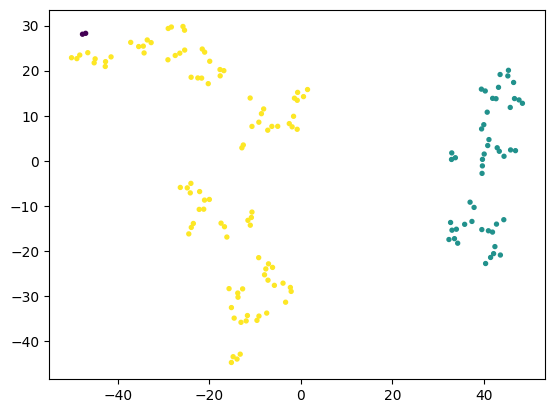

In [10]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.8, min_samples=5).fit(X)
plt.scatter(Embedded[:,0],Embedded[:,1],c=clustering.labels_,s=8)

Let's validate it..

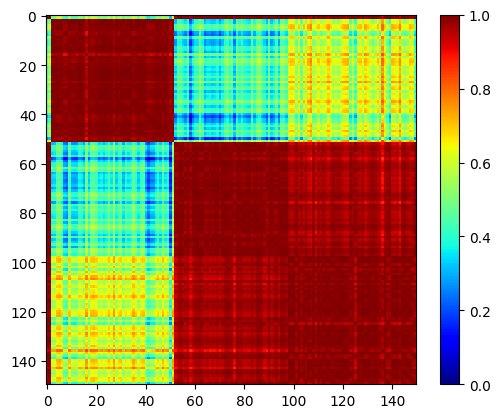

In [11]:
clf = clustering

# pairwisedist = pairwise_distances(scaleddf, metric='cosine')
pairwisedist = pairwise_distances(X, metric='cosine')

# sorting by labels
sorted_pairwisedist = pairwisedist[np.argsort(clf.labels_)][:, np.argsort(clf.labels_)]
labels = clf.labels_[np.argsort(clf.labels_)]

# keeping the distance values between 0 and 1.
sorted_pairwisedist = sorted_pairwisedist / np.max(sorted_pairwisedist)
sorted_similarity = 1- sorted_pairwisedist / np.max(sorted_pairwisedist)

#plotting
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(sorted_similarity,cmap ='jet',interpolation='none')
plt.colorbar()


## Let's try hierachical clustering

In [12]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
# clustering = AgglomerativeClustering().fit(X)
# plt.scatter(Embedded[:,0],Embedded[:,1],c=clustering.labels_,s=8)

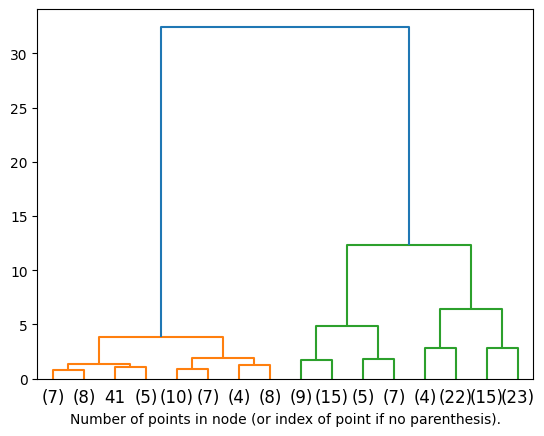

In [13]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


It seems like that 3 cluster is a good choice

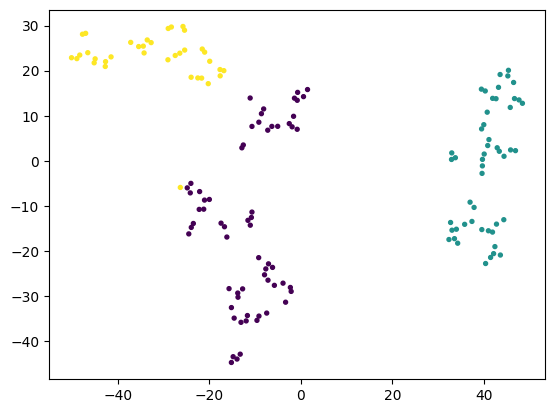

In [14]:
model = AgglomerativeClustering(distance_threshold=None, n_clusters=3)

model = model.fit(X)
plt.scatter(Embedded[:,0],Embedded[:,1],c=model.labels_,s=8)

### Let's try to validate

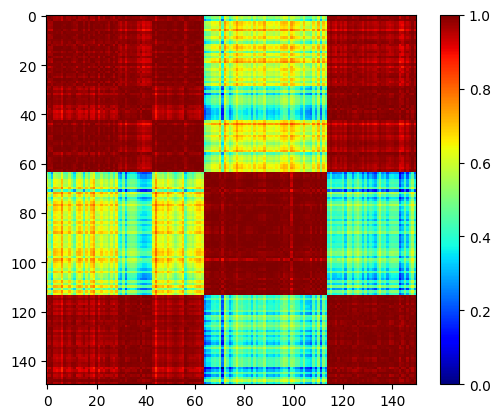

In [15]:
# ported from: https://medium.com/@devamsheth20/statistical-test-for-k-means-cluster-validation-in-python-using-sorted-similarity-matrix-1e644ab029c0
import numpy as np
from sklearn.metrics import pairwise_distances

from sklearn.cluster import KMeans

model = AgglomerativeClustering(distance_threshold=None, n_clusters=3)
model = model.fit(X)
clf = model

# pairwisedist = pairwise_distances(scaleddf, metric='cosine')
pairwisedist = pairwise_distances(X, metric='cosine')

# sorting by labels
sorted_pairwisedist = pairwisedist[np.argsort(clf.labels_)][:, np.argsort(clf.labels_)]
labels = clf.labels_[np.argsort(clf.labels_)]

# keeping the distance values between 0 and 1.
sorted_pairwisedist = sorted_pairwisedist / np.max(sorted_pairwisedist)
sorted_similarity = 1- sorted_pairwisedist / np.max(sorted_pairwisedist)

#plotting
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(sorted_similarity,cmap ='jet',interpolation='none')
plt.colorbar()


## Direct Visualization of Clusters

In [16]:
X2 = X.copy()
X2['cluster'] = (model.labels_+1)
X2['True_Label'] = (y+1)
X2

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),cluster,True_Label
0,5.1,3.5,1.4,0.2,2,1
1,4.9,3.0,1.4,0.2,2,1
2,4.7,3.2,1.3,0.2,2,1
3,4.6,3.1,1.5,0.2,2,1
4,5.0,3.6,1.4,0.2,2,1
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,3,3
146,6.3,2.5,5.0,1.9,1,3
147,6.5,3.0,5.2,2.0,3,3
148,6.2,3.4,5.4,2.3,3,3


In [17]:
X2 = X2.sort_values(['cluster','True_Label'])
X_new = X2.iloc[:,:]
X_new

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),cluster,True_Label
50,7.0,3.2,4.7,1.4,1,2
51,6.4,3.2,4.5,1.5,1,2
52,6.9,3.1,4.9,1.5,1,2
53,5.5,2.3,4.0,1.3,1,2
54,6.5,2.8,4.6,1.5,1,2
...,...,...,...,...,...,...
143,6.8,3.2,5.9,2.3,3,3
144,6.7,3.3,5.7,2.5,3,3
145,6.7,3.0,5.2,2.3,3,3
147,6.5,3.0,5.2,2.0,3,3


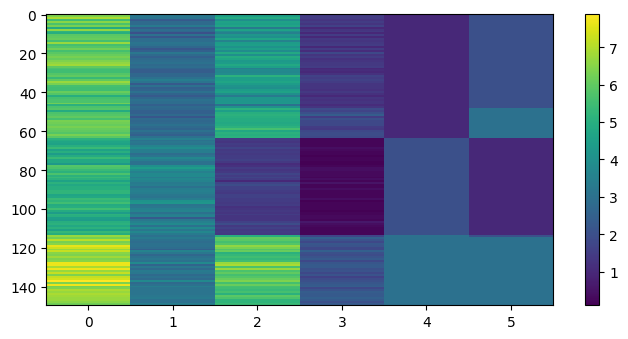

In [18]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.imshow(X_new.values, aspect='auto',interpolation='none')
plt.colorbar()
plt.show()

## Inspect the average of all records in all clusters.

In [19]:
X_new.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'cluster', 'True_Label'],
      dtype='object')

In [20]:
ClusterAverage = X_new.groupby(['cluster'])['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'].mean()
ClusterAverage

<ipython-input-20-27119a60dfcf>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ClusterAverage = X_new.groupby(['cluster'])['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
cluster,,,,
1,5.920312,2.751562,4.420312,1.434375
2,5.006000,3.428000,1.462000,0.246000
3,6.869444,3.086111,5.769444,2.105556


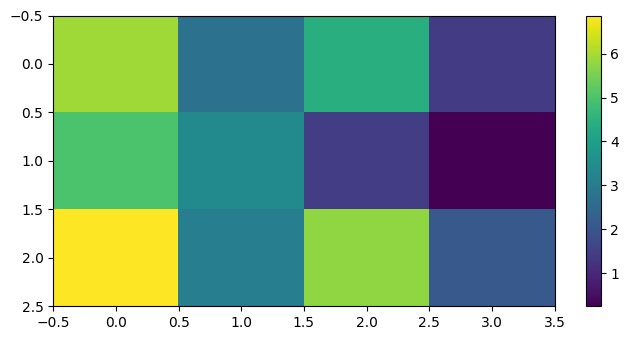

In [21]:
plt.imshow(ClusterAverage.values, aspect='auto',interpolation='none')
plt.colorbar()
plt.show()

#### Let's try another popular diagram, the Radar Plot.

In [22]:
from scipy import stats
import plotly.express as px

values = np.array([])
variables = []
clusters = []
df = ClusterAverage.copy()
# for c in df.columns:
#   df[c] = stats.zscore(df[c])

# variables.append(ClusterAverage.columns.values)
for r in range(df.shape[0]):
  rowContent = df.iloc[r,:]
  values = np.append(values, rowContent, axis=0)
  variables.extend(df.columns.values.tolist())
  clusters.extend([str(r+1)]*df.shape[1])
  # values.append(rowContent.values)

df = pd.DataFrame(dict(
    value = values,
    variable = variables,
    group = clusters))

fig = px.line_polar(df, r = 'value', theta = 'variable', line_close = True,
                    color = 'group')
fig.update_traces(fill = 'toself')

fig.show()

In [23]:
from scipy import stats

values = np.array([])
variables = []
clusters = []
df = ClusterAverage.copy()
for c in df.columns:
  df[c] = stats.zscore(df[c])

# variables.append(ClusterAverage.columns.values)
for r in range(df.shape[0]):
  rowContent = df.iloc[r,:]
  values = np.append(values, rowContent, axis=0)
  variables.extend(df.columns.values.tolist())
  clusters.extend([str(r+1)]*df.shape[1])
  # values.append(rowContent.values)

df = pd.DataFrame(dict(
    value = values,
    variable = variables,
    group = clusters))

fig = px.line_polar(df, r = 'value', theta = 'variable', line_close = True,
                    color = 'group')
fig.update_traces(fill = 'toself',textposition = 'top center')

fig.show()

## Let's try another way of grouping the clustered dataset w.r.t. the labels.

In [24]:
ClusterAverage = X_new.groupby(['cluster','True_Label'])['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'].mean()
ClusterAverage

<ipython-input-24-de4210467153>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



sepal length (cm)  sepal width (cm)  petal length (cm)  \
cluster True_Label                                                           
1       2                    5.920408          2.765306           4.244898   
        3                    5.920000          2.706667           4.993333   
2       1                    5.006000          3.428000           1.462000   
3       2                    6.700000          3.000000           5.000000   
        3                    6.874286          3.088571           5.791429   

                    petal width (cm)  
cluster True_Label                    
1       2                   1.318367  
        3                   1.813333  
2       1                   0.246000  
3       2                   1.700000  
        3                   2.117143

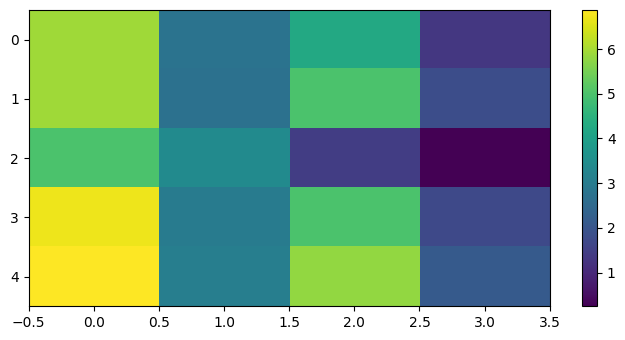

In [25]:
plt.imshow(ClusterAverage.values, aspect='auto',interpolation='none')
plt.colorbar()
plt.show()

In [26]:
ClusterAverage = X_new.groupby(['True_Label','cluster'])['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'].mean()
ClusterAverage


<ipython-input-26-68b2e284e40e>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



sepal length (cm)  sepal width (cm)  petal length (cm)  \
True_Label cluster                                                           
1          2                 5.006000          3.428000           1.462000   
2          1                 5.920408          2.765306           4.244898   
           3                 6.700000          3.000000           5.000000   
3          1                 5.920000          2.706667           4.993333   
           3                 6.874286          3.088571           5.791429   

                    petal width (cm)  
True_Label cluster                    
1          2                0.246000  
2          1                1.318367  
           3                1.700000  
3          1                1.813333  
           3                2.117143

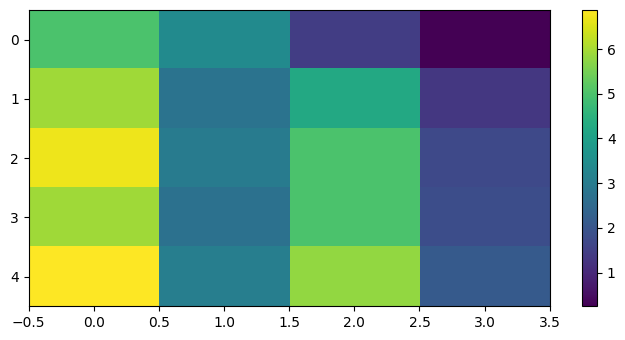

In [27]:
# plt.imshow(ClusterAverage.values, aspect='auto',interpolation='none', origin="lower")
plt.imshow(ClusterAverage.values, aspect='auto',interpolation='none')

plt.colorbar()
plt.show()

## Cluster visualization using the Seaborn library

\Let's fetch 3 samples from each group for visualization purpose

In [28]:
X_vis = X_new.groupby(['True_Label','cluster']).sample(n=2, replace=True).sort_values(['True_Label','cluster'])

In [29]:
X_vis_true_label = X_vis.loc[:,'True_Label']
X_vis_cluster = X_vis.loc[:,'cluster']
X_vis = X_vis.drop(columns=['cluster','True_Label'])

In [30]:
X_vis.shape

(10, 4)

Let's give it a trial.

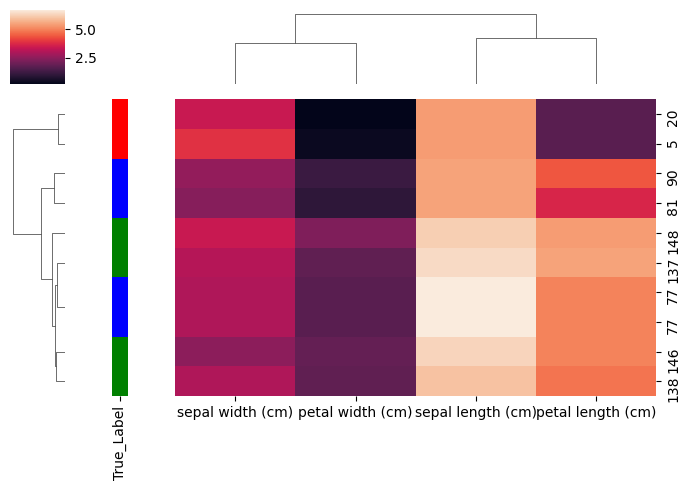

In [31]:
import seaborn as sns

lut = dict(zip(X_vis_true_label.unique(), "rbg"))
row_colors = X_vis_true_label.map(lut)

g = sns.clustermap(
    X_vis,
    figsize=(7, 5),
    dendrogram_ratio=(.1, .2),
    # cbar_pos=(0, .2, .03, .4),
    # cmap="vlag", vmin=0, vmax=400,
    # cbar_pos=(.02, .32, .03, .2),
    row_colors=row_colors
)
# g.ax_col_dendrogram.remove()


What if we don't resample the dataset?

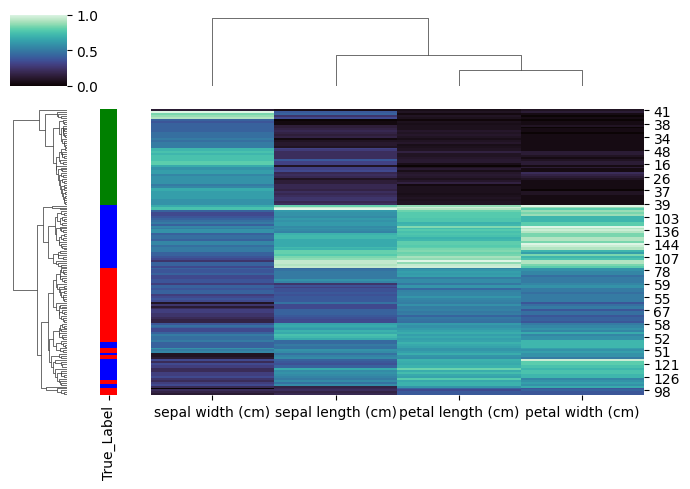

In [32]:
import seaborn as sns

lut = dict(zip(X_new.True_Label.unique(), "rbg"))
row_colors = X_new.True_Label.map(lut)

sns.clustermap(
    X_new.drop(columns=['cluster','True_Label']),
    figsize=(7, 5),
    dendrogram_ratio=(.1, .2),
    cbar_pos=(0, .2, .03, .4),
    cmap="mako", standard_scale=1,
    row_colors=row_colors
)